<a href="https://colab.research.google.com/github/agasthya-karna/MacLear/blob/main/House_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

from scipy.stats import probplot, boxcox
from scipy.special import inv_boxcox
import pylab

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf

# **DATA GLOSSARY**

**BHK:** Number of Bedrooms, Hall, Kitchen.

**Rent:** Rent of the Houses/Apartments/Flats.

**Size:** Size of the Houses/Apartments/Flats in Square Feet.

**Floor:** Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.)

**Area Type:** Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area.

**Area Locality:** Locality of the Houses/Apartments/Flats.

**City:** City where the Houses/Apartments/Flats are Located.

**Furnishing Status:** Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished.

**Tenant Preferred:** Type of Tenant Preferred by the Owner or Agent.

**Bathroom:** Number of Bathrooms.

**Point of Contact:** Whom should you contact for more information regarding the Houses/Apartments/Flats.

# **Importing Data**

In [153]:
df = pd.read_csv('/content/drive/MyDrive/housepred/House_Rent_Dataset.csv')
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [154]:
 print(df.shape)

(4746, 12)


In [155]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB
None


In [156]:
print(df.columns)

Index(['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type',
       'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred',
       'Bathroom', 'Point of Contact'],
      dtype='object')


In [157]:
print(df.dtypes)

Posted On            object
BHK                   int64
Rent                  int64
Size                  int64
Floor                object
Area Type            object
Area Locality        object
City                 object
Furnishing Status    object
Tenant Preferred     object
Bathroom              int64
Point of Contact     object
dtype: object


**Checking missing values**

In [158]:
print(df.isnull().sum())

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64


In [159]:
print(df.describe().T)

           count          mean           std     min      25%      50%  \
BHK       4746.0      2.083860      0.832256     1.0      2.0      2.0   
Rent      4746.0  34993.451327  78106.412937  1200.0  10000.0  16000.0   
Size      4746.0    967.490729    634.202328    10.0    550.0    850.0   
Bathroom  4746.0      1.965866      0.884532     1.0      1.0      2.0   

              75%        max  
BHK           3.0        6.0  
Rent      33000.0  3500000.0  
Size       1200.0     8000.0  
Bathroom      2.0       10.0  


In [160]:
df['Area Type'].value_counts()


Super Area     2446
Carpet Area    2298
Built Area        2
Name: Area Type, dtype: int64

**Exploratory Data Analysis**

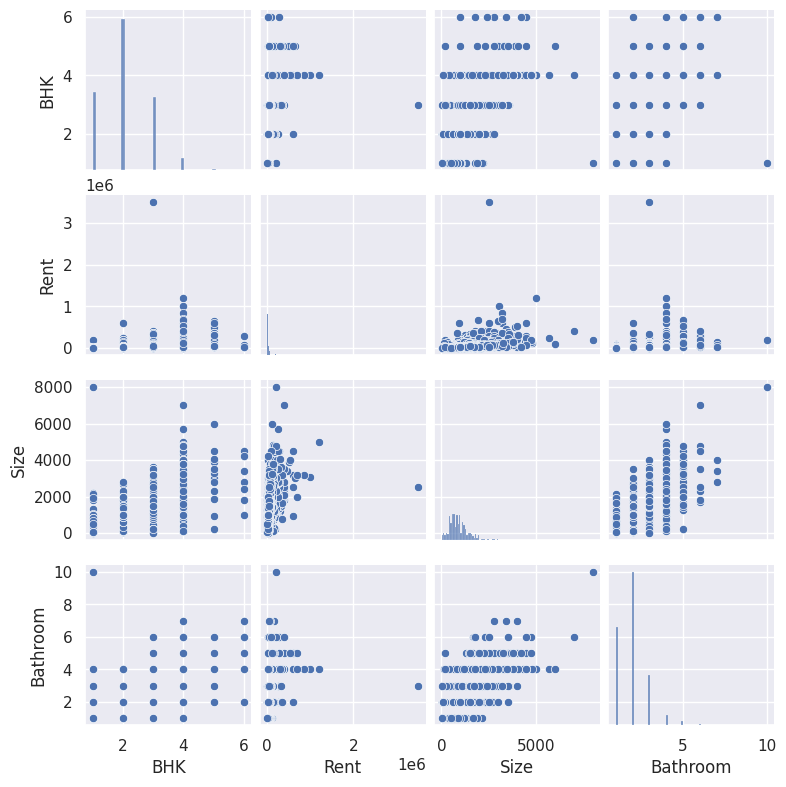

In [161]:
sns.pairplot(df,height=2)
plt.show()

In [162]:
fig = px.histogram(df,x='Rent',color_discrete_sequence = px.colors.qualitative.Set3, title=" Prices Distribution of Rent Histogram")
fig.show()
fig = px.box(df, x="Rent", title='Boxplot for Rent Prices')
fig.show()

Observation: We can see that there is an outlier after 2M . We remove it

Detecting and removing the outlier

In [163]:
print(np.where(df['Rent']>2000000))

(array([1837]),)


In [164]:
df.drop([1837], axis=0, inplace=True)

fig = px.box(df, x="Rent",title='Boxplot for Rent Prices')
fig.show()

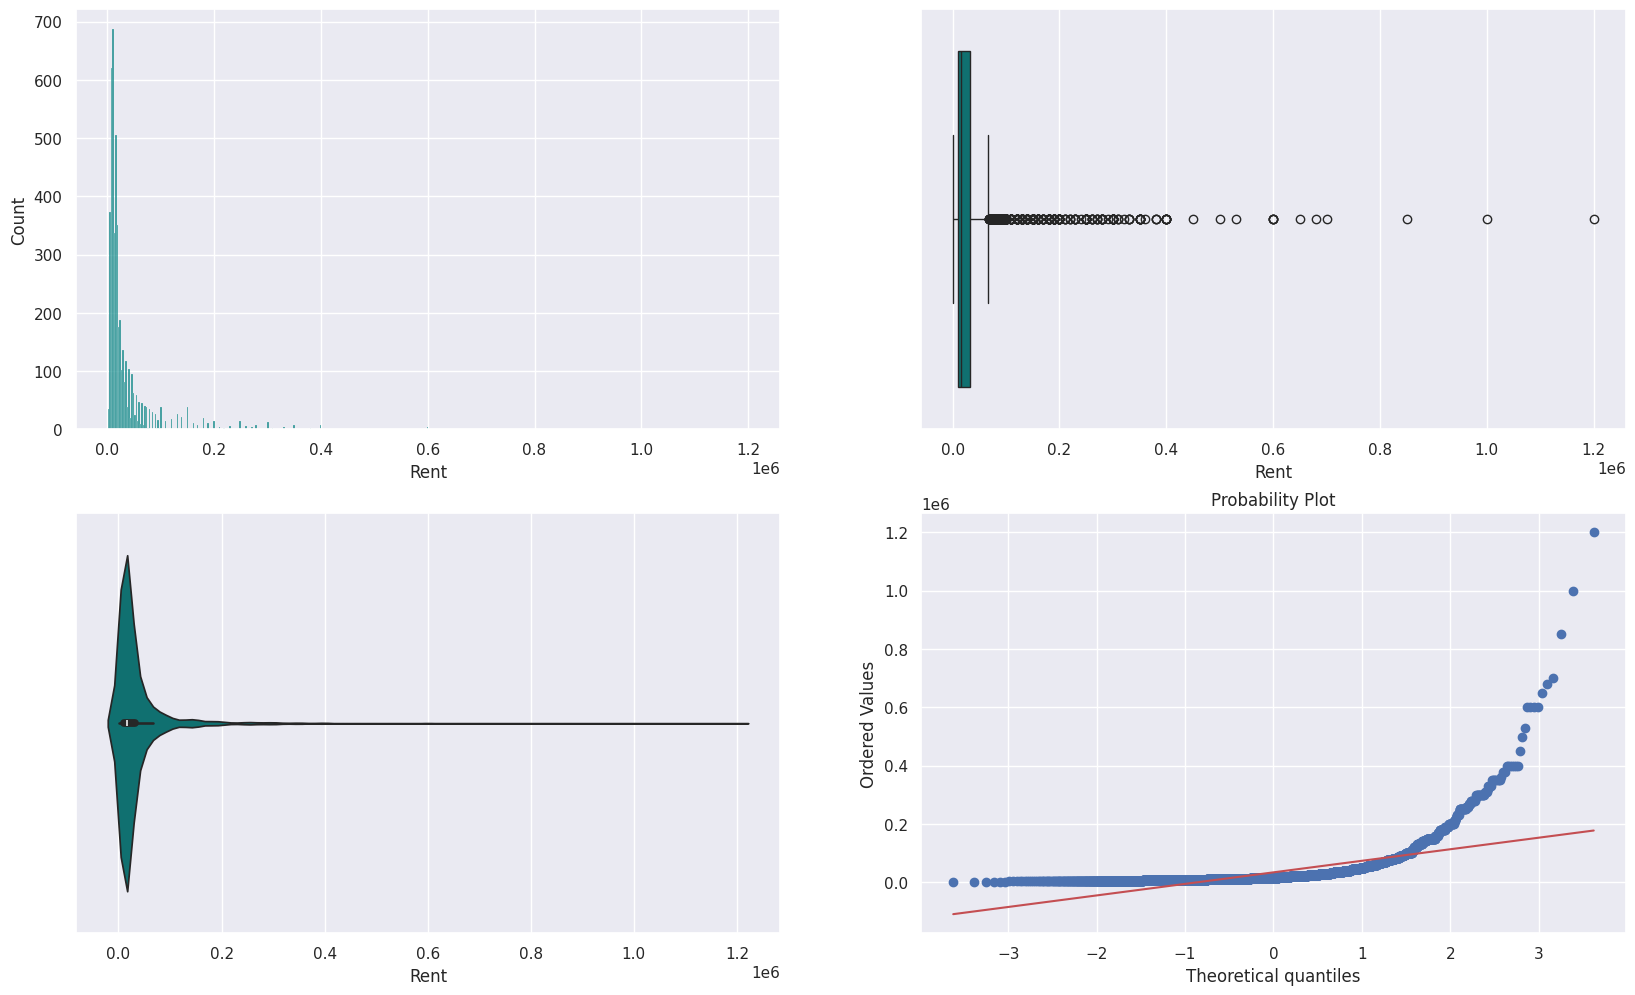

In [165]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = df['Rent'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x =df ['Rent'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x =df['Rent'], ax= ax[1, 0], color= 'teal')
ax4 = probplot(df['Rent'], plot=pylab)
pylab.show()

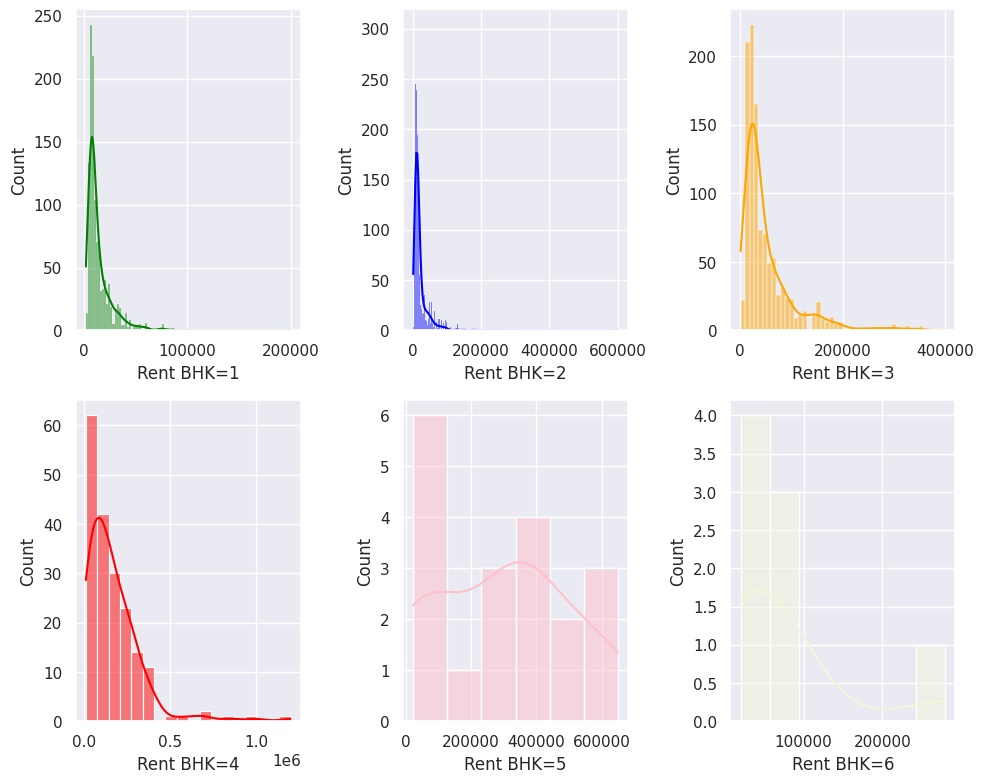

In [166]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,8))
sns.histplot(data=df[df['BHK'] == 1], ax=axs[0, 0], x='Rent', kde=True, color='green')
axs[0,0].set(xlabel='Rent BHK=1')

sns.histplot(data=df[df['BHK'] == 2], ax=axs[0, 1], x='Rent', kde=True, color='blue')
axs[0,1].set(xlabel='Rent BHK=2')

sns.histplot(data=df[df['BHK'] == 3], ax=axs[0, 2], x='Rent', kde=True, color='orange')
axs[0,2].set(xlabel='Rent BHK=3')

sns.histplot(data=df[df['BHK'] == 4], ax=axs[1, 0], x='Rent', kde=True, color='red')
axs[1,0].set(xlabel='Rent BHK=4')

sns.histplot(data=df[df['BHK'] == 5], ax=axs[1, 1], x='Rent', kde=True, color='pink')
axs[1,1].set(xlabel='Rent BHK=5')

sns.histplot(data=df[df['BHK'] == 6], ax=axs[1, 2], x='Rent', kde=True, color='beige')
axs[1,2].set(xlabel='Rent BHK=6')

plt.tight_layout()
plt.show()

<ipython-input-167-caa7fab1dfd1>:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.




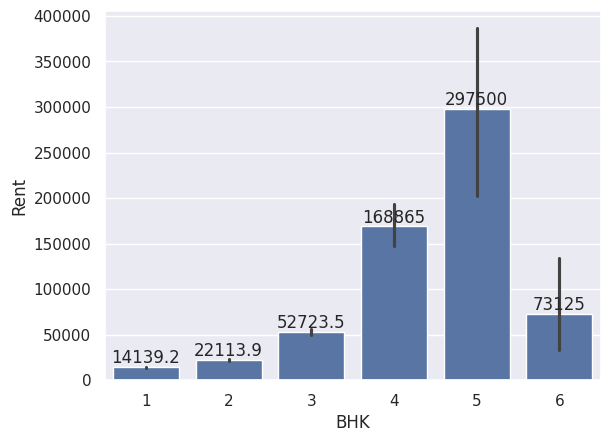

In [167]:
fig, ax = plt.subplots()
sns.barplot(data=df, x='BHK', y='Rent', ci=95, estimator=np.mean, ax=ax)
ax.bar_label(ax.containers[0])
plt.show()

In [168]:
fig = px.pie(df, names='BHK', height=700, width= 700, color_discrete_sequence=px.colors.sequential.deep, title='Pie Chart for different number of BHKs present in Houses available for Rent')
fig.update_traces(textfont_size=15)
fig.show()

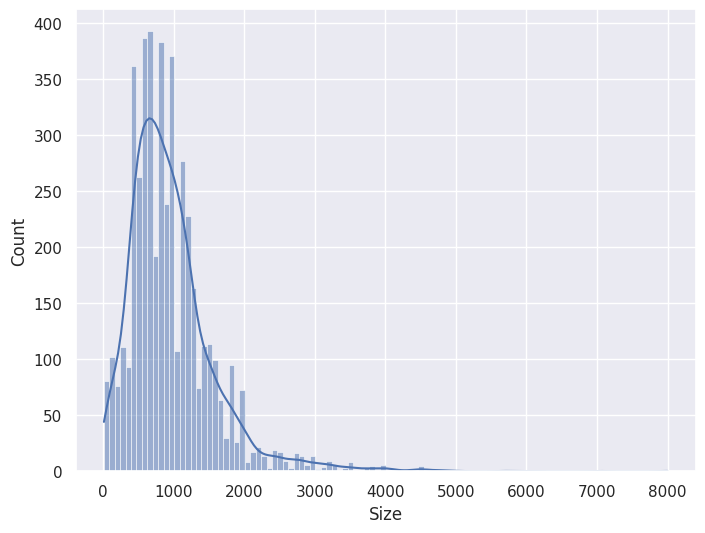

In [169]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=df, x='Size', kde=True, ax=ax)
plt.show()

<ipython-input-170-057e6d8680e7>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




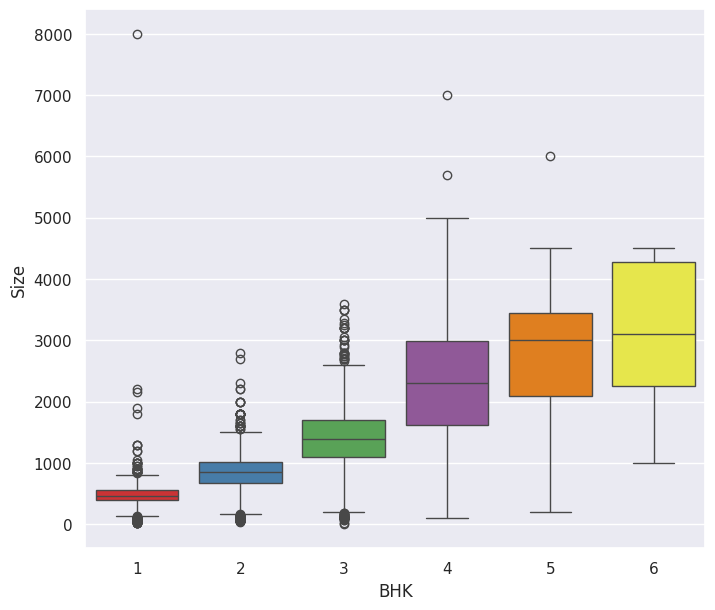

In [170]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=df, x='BHK', y='Size', palette='Set1', ax=ax)
plt.show()

As anticipated, size generally increases with BHK. However, outliers are evident across different BHK values. I intend to retain high-valued outliers as they exhibit a linear increase in medians with BHK, preserving the authenticity of the data. Nevertheless, I'll address low-valued outliers by replacing them with a value calculated as (0.25 quantile - 1.5 * IQR).

In [171]:
for BHK in [1, 2, 3]:
    size_values = df[df['BHK'] == BHK]['Size']
    q3 = size_values.quantile(0.75)
    q1 = size_values.quantile(0.25)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    size_values = size_values.apply(lambda x: x if x >= lower_limit else lower_limit)
    df.loc[df['BHK'] == BHK, 'Size'] = size_values

<ipython-input-172-057e6d8680e7>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




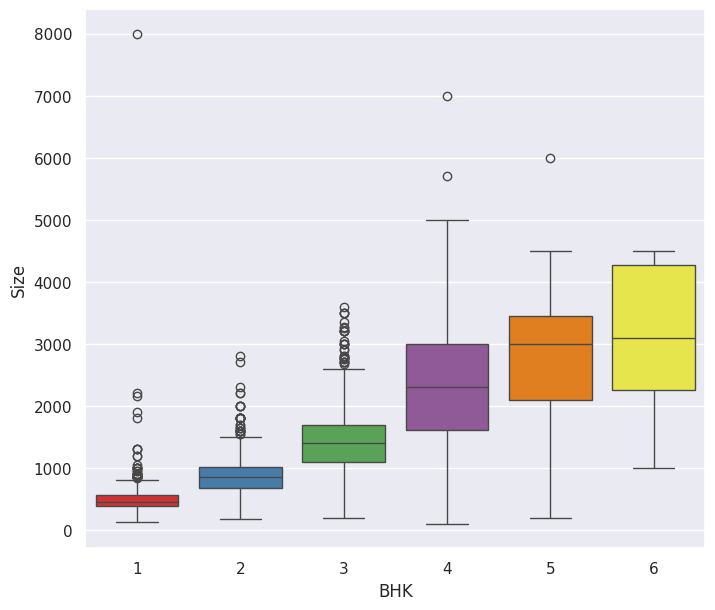

In [172]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=df, x='BHK', y='Size', palette='Set1', ax=ax)
plt.show()

In [173]:
df[df['Size'] == 8000]
df.drop(4185, axis=0, inplace=True)

Floor exploration

In [174]:
df_1 = df.copy()
def modify_floor(x):
    x = x.replace('Ground', '0')
    x = x.replace('Upper Basement', '-1')
    x = x.replace('Lower Basement', '-2')
    return x

In [175]:
df_temp = df.copy()
df_temp['Floor'] = df_temp['Floor'].apply(lambda x: modify_floor(x))
df_temp = df_temp['Floor'].str.split(' out of ', expand=True).rename(columns={0:'Floor', 1:'Total Floors'})
df_1['Floor'] = df_temp['Floor']
df_1['Total Floors'] = df_temp['Total Floors']

In [176]:
df_1.head(3)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Total Floors
0,2022-05-18,2,10000,1100,0,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,2
1,2022-05-13,2,20000,800,1,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3
2,2022-05-16,2,17000,1000,1,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3


In [177]:
df_1[df_1['Total Floors'].isna()]

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Total Floors
2553,2022-06-18,2,20000,400,3,Super Area,"Kasturba Niketan, Lajpat Nagar 2",Delhi,Unfurnished,Bachelors/Family,1,Contact Owner,None
2883,2022-05-23,1,18000,450,0,Carpet Area,"DDA Flat AD Block, Shalimar Bagh AD Block",Delhi,Furnished,Bachelors/Family,1,Contact Owner,None
4490,2022-06-12,3,15000,900,1,Super Area,"Malakpet, NH 9",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner,None
4560,2022-05-31,3,15000,1270,1,Carpet Area,Tarnaka,Hyderabad,Furnished,Family,2,Contact Owner,None


In [178]:
print(df_1.shape[0])
df_1 = df_1.dropna()
print(df_1.shape[0])

4744
4740


In [179]:
df_1['Floor'] = df_1['Floor'].astype(int)
df_1['Total Floors'] = df_1['Total Floors'].astype(int)

In [180]:
df = df_1

AREA exploration

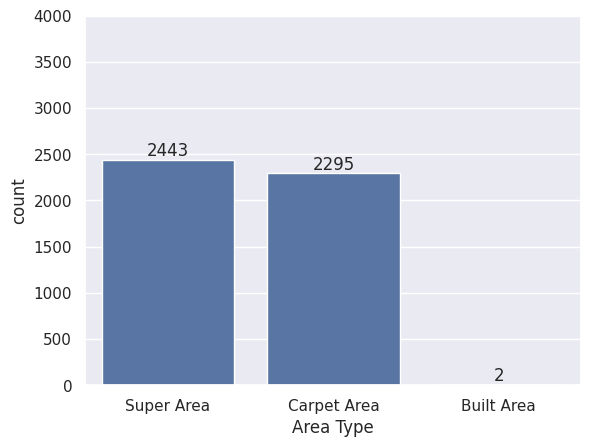

In [181]:
fig, ax = plt.subplots()
sns.countplot(data = df, x='Area Type', ax=ax)
ax.bar_label(ax.containers[0])
ax.set(ylim=(0,4000))
plt.show()

<ipython-input-182-f6f8b8d00318>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




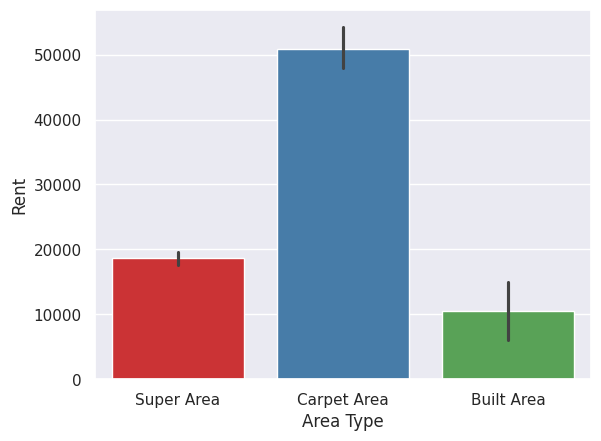

In [182]:
fig, ax = plt.subplots()
sns.barplot(data=df, x='Area Type', y='Rent', palette='Set1', ax=ax)
plt.show()

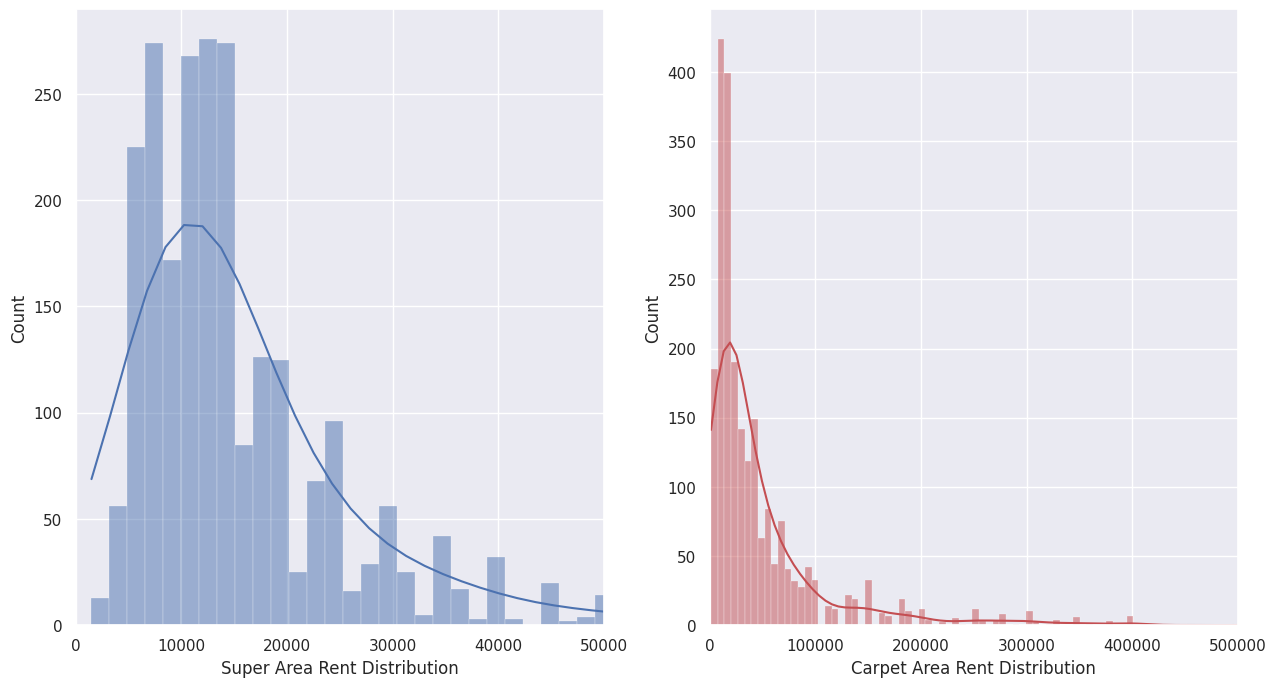

In [183]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.histplot(data=df[df['Area Type'] == 'Super Area'], x='Rent', kde=True, ax=axs[0], color='b')
axs[0].set(xlim=(0, 50000), xlabel="Super Area Rent Distribution")

sns.histplot(data=df[df['Area Type'] == 'Carpet Area'], x='Rent', kde=True, ax=axs[1], color='r')
axs[1].set(xlim=(0, 500000), xlabel="Carpet Area Rent Distribution")

plt.show()

<Figure size 1000x600 with 0 Axes>

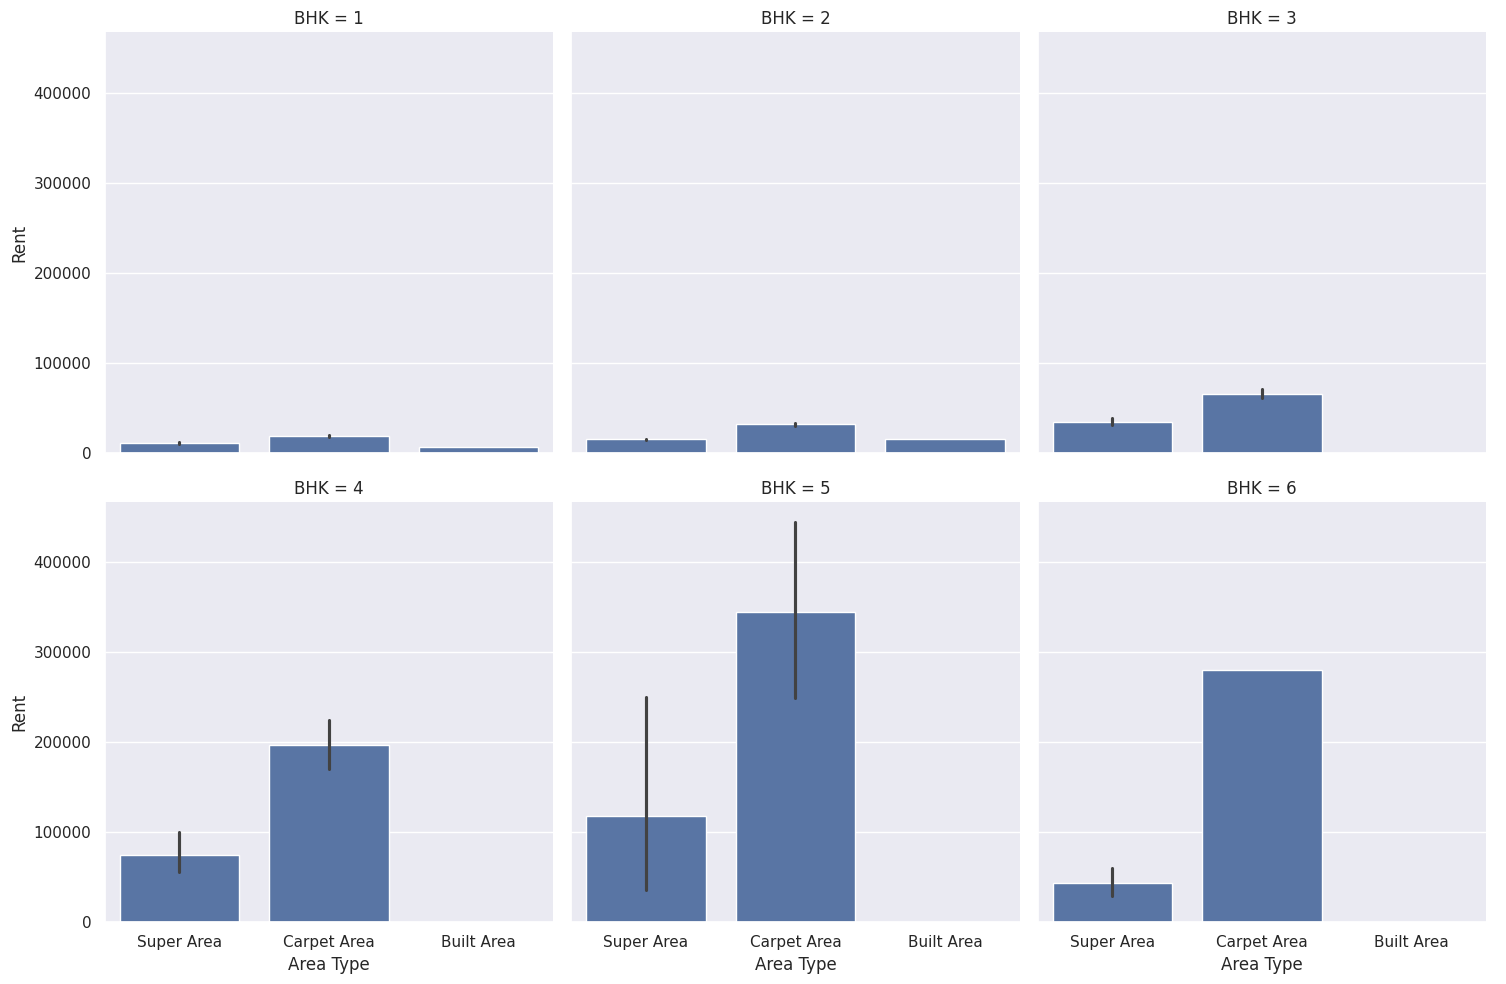

In [184]:
plt.figure(figsize=(10,6))
sns.catplot(data=df, x='Area Type', y='Rent', kind='bar', col='BHK', col_wrap=3)
plt.tight_layout()
plt.show()

In [185]:
df.head(3)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Total Floors
0,2022-05-18,2,10000,1100,0,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,2
1,2022-05-13,2,20000,800,1,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3
2,2022-05-16,2,17000,1000,1,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3


**AREA LOCALITY exploration**

In [186]:
atleast_20 = df['Area Locality'].value_counts().to_frame().reset_index().head(6)['index'].tolist()
atleast_20

['Bandra West',
 'Gachibowli',
 'Electronic City',
 'Miyapur, NH 9',
 'Velachery',
 'Madipakkam']

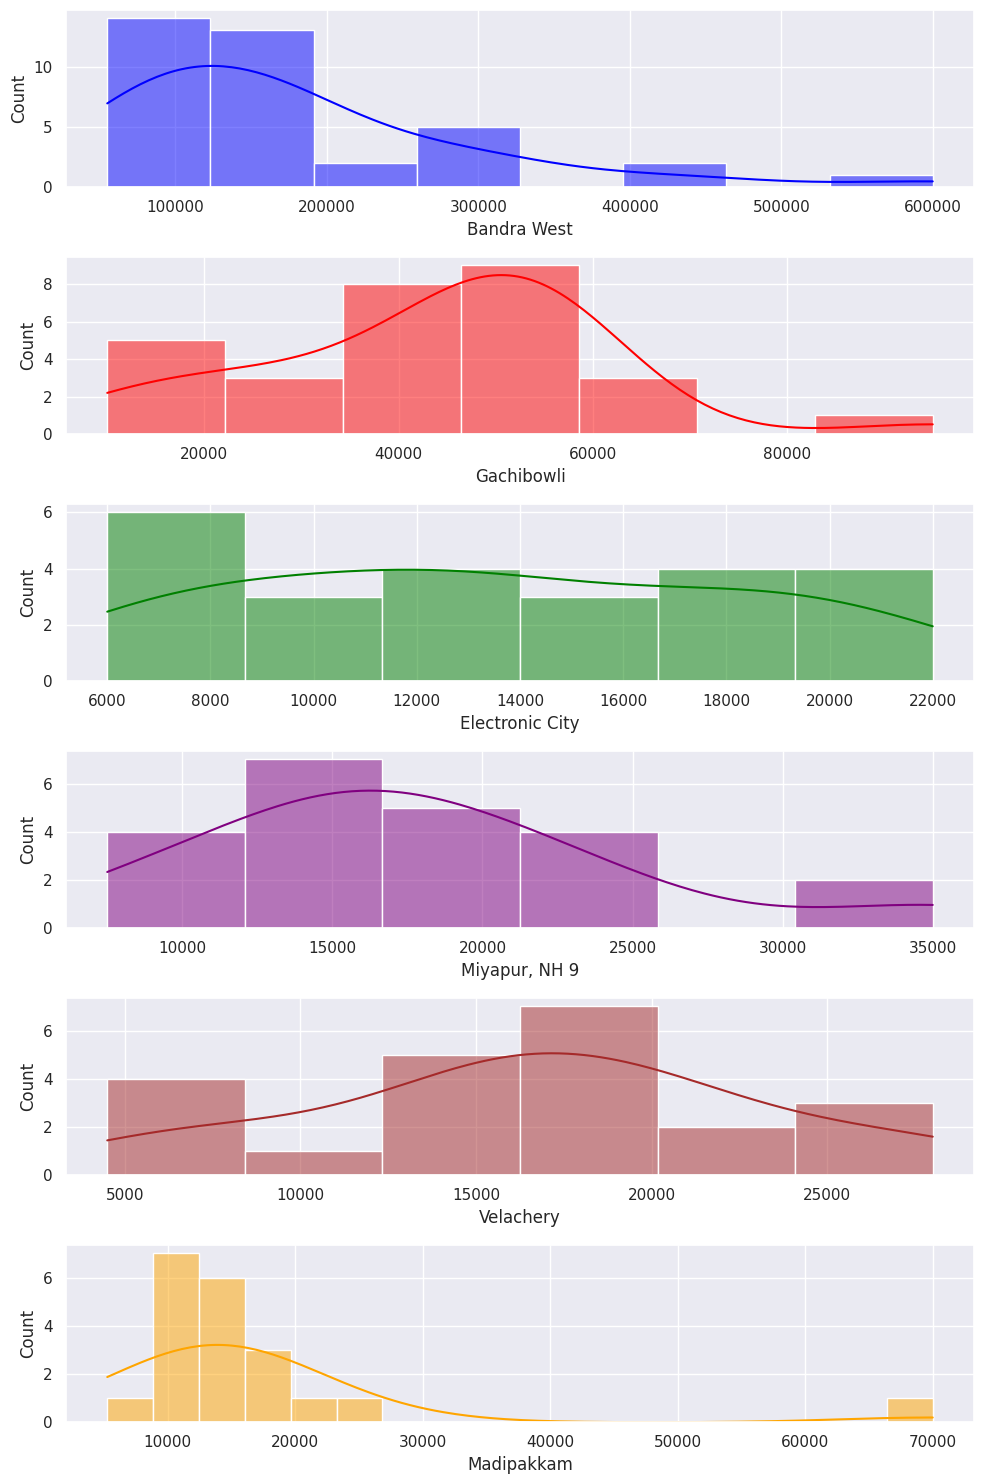

In [187]:
colors=['blue', 'red', 'green', 'purple', 'brown', 'orange']
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(10, 15))
for idx, locality in enumerate(atleast_20):
    sns.histplot(kde=True, data = df[df['Area Locality']==locality], x='Rent', ax=axs[idx], color=colors[idx])
    axs[idx].set(xlabel=f"{locality}")

plt.tight_layout()
plt.show()

**CITY exploration**

<ipython-input-188-1ae77c434b85>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




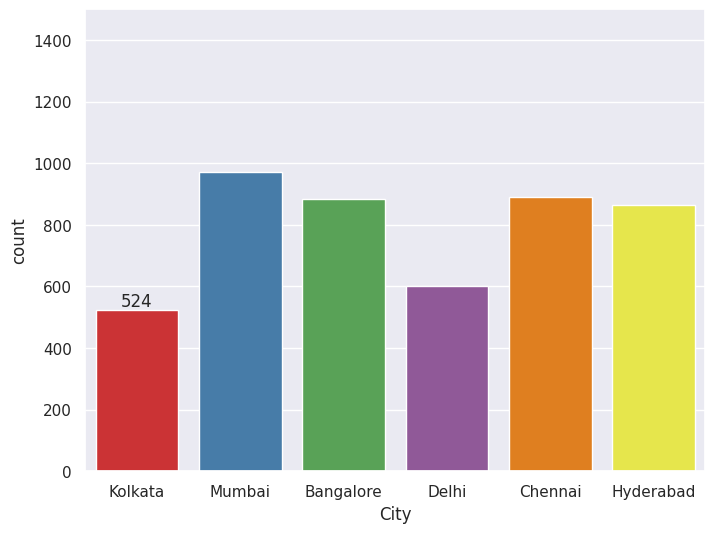

In [188]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x='City', palette='Set1')
ax.bar_label(ax.containers[0])
ax.set(ylim=(0, 1500))
plt.show()

<Figure size 800x600 with 0 Axes>

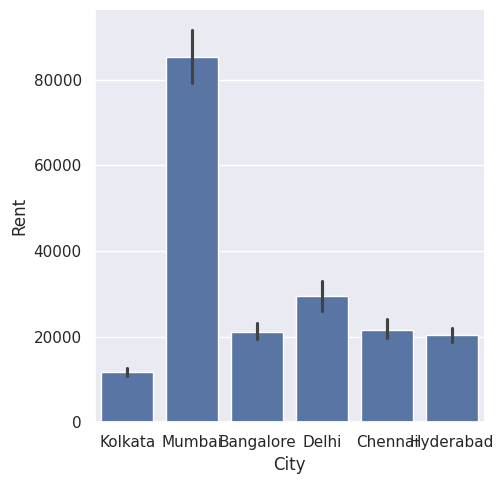

In [189]:
plt.figure(figsize=(8, 6))
sns.catplot(kind='bar', data=df, x='City', y='Rent')
plt.show()

<ipython-input-190-c773de738721>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




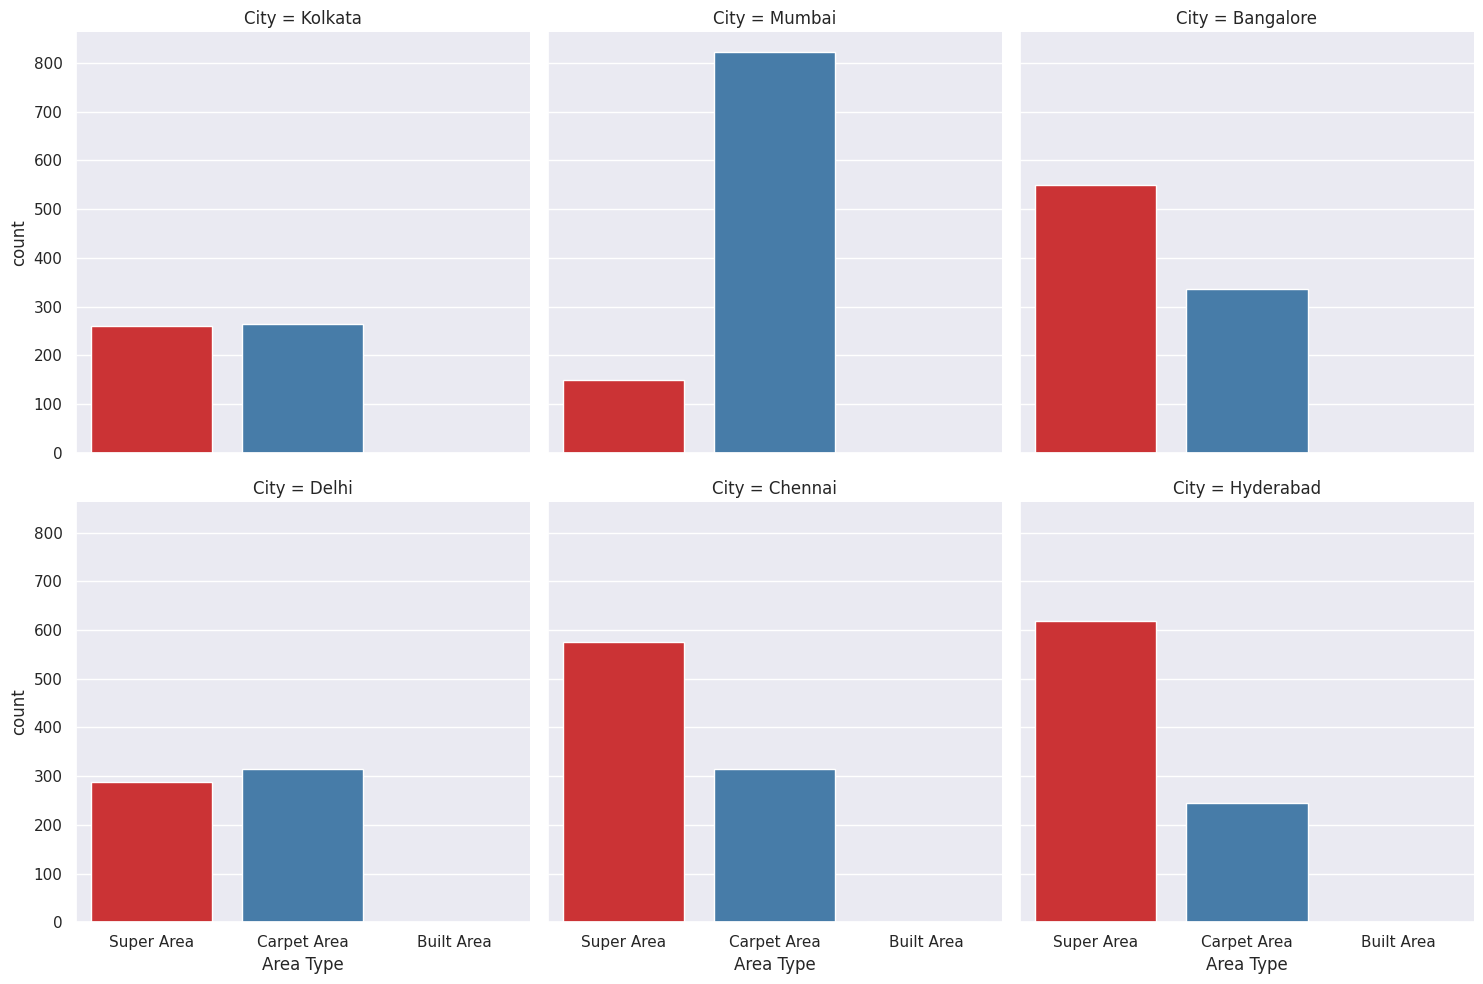

In [190]:
sns.catplot(kind='count', data=df, x='Area Type', col = 'City', col_wrap=3, palette='Set1')

**Furnishing Status**

<ipython-input-191-f5cc263d7ed1>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




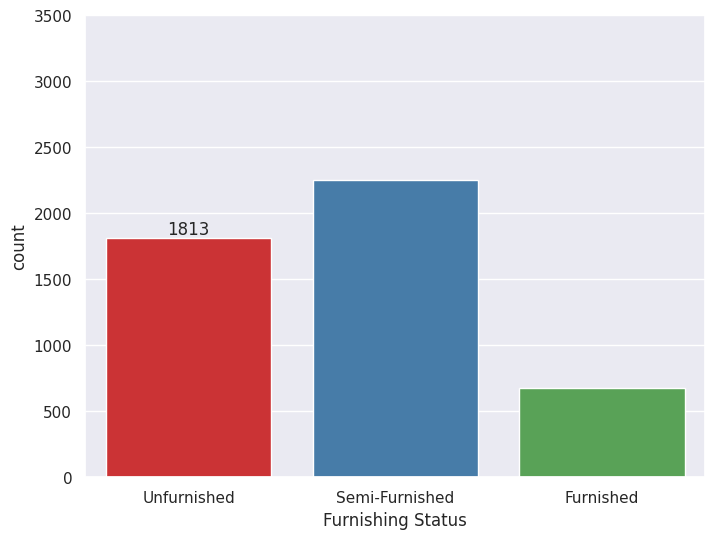

In [191]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x='Furnishing Status', palette='Set1')
ax.bar_label(ax.containers[0])
ax.set(ylim=(0, 3500))
plt.show()

<ipython-input-192-863e4e53a0b1>:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.




<Figure size 800x600 with 0 Axes>

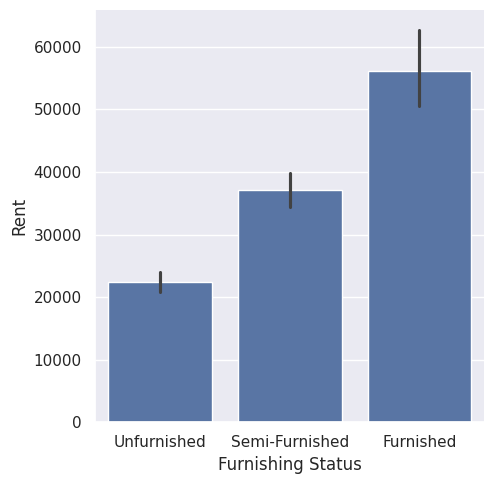

In [192]:
plt.figure(figsize=(8, 6))
sns.catplot(kind='bar', data=df, x='Furnishing Status', y='Rent', ci=95)
plt.show()

In [193]:
df.head(3)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Total Floors
0,2022-05-18,2,10000,1100,0,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,2
1,2022-05-13,2,20000,800,1,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3
2,2022-05-16,2,17000,1000,1,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3


In [194]:
df['Tenant Preferred'].value_counts()


Bachelors/Family    3440
Bachelors            829
Family               471
Name: Tenant Preferred, dtype: int64

<ipython-input-195-c114ef908278>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




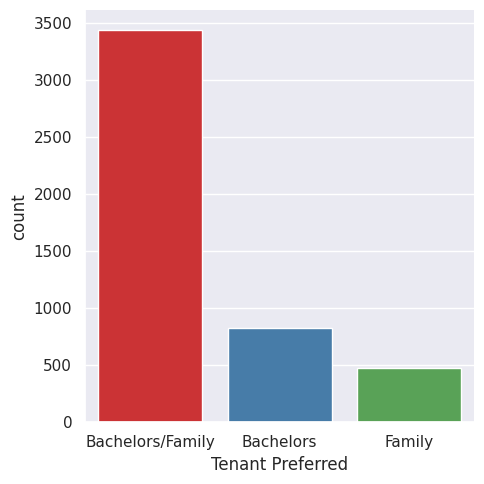

In [195]:
sns.catplot(kind='count', data=df, x='Tenant Preferred', palette='Set1')

**Bathroom**

In [196]:
df['Bathroom'].value_counts()


2    2290
1    1472
3     747
4     156
5      60
6      12
7       3
Name: Bathroom, dtype: int64

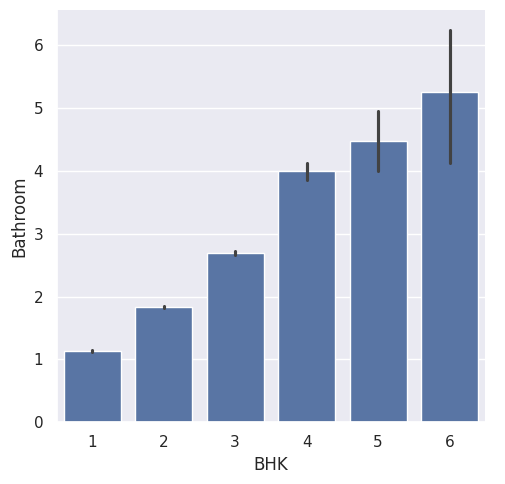

In [197]:
sns.catplot(data=df, x='BHK', y='Bathroom', kind='bar')


**Point of Contact**

In [198]:
df['Point of Contact'].value_counts()

Contact Owner      3211
Contact Agent      1528
Contact Builder       1
Name: Point of Contact, dtype: int64

In [199]:
df['Month'] = pd.to_datetime(df['Posted On']).dt.month
df['Day'] = pd.to_datetime(df['Posted On']).dt.day

In [200]:
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Total Floors,Month,Day
0,2022-05-18,2,10000,1100,0,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,2,5,18
1,2022-05-13,2,20000,800,1,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,5,13
2,2022-05-16,2,17000,1000,1,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,5,16
3,2022-07-04,2,10000,800,1,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2,7,4
4,2022-05-09,2,7500,850,1,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2,5,9


In [201]:
df.drop('Posted On', axis=1, inplace=True)

<ipython-input-202-f093384c7b79>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




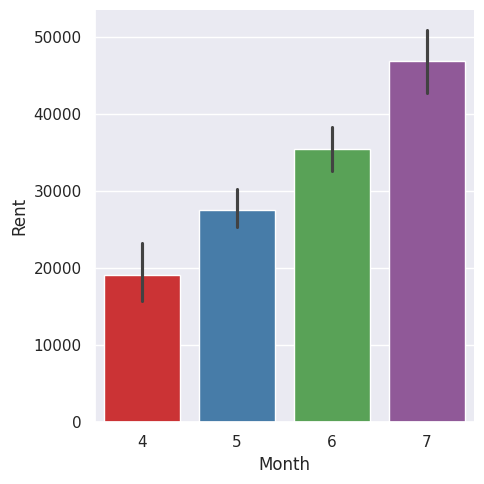

In [202]:
sns.catplot(data=df, kind='bar', x='Month', y='Rent', palette='Set1')

The rent tends to be about proportional to the month it's sold in, with August months being the most expensive, and the least being April.



In [203]:
def quantize_day(day):
    if day < 10:
        return 'low'
    if day < 20:
        return 'medium'
    if day <= 31:
        return 'high'

In [204]:
df['Day'] = df['Day'].apply(lambda day: quantize_day(day))


In [205]:
df['Day'].value_counts()

high      1801
low       1657
medium    1282
Name: Day, dtype: int64

<ipython-input-206-d61782341986>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




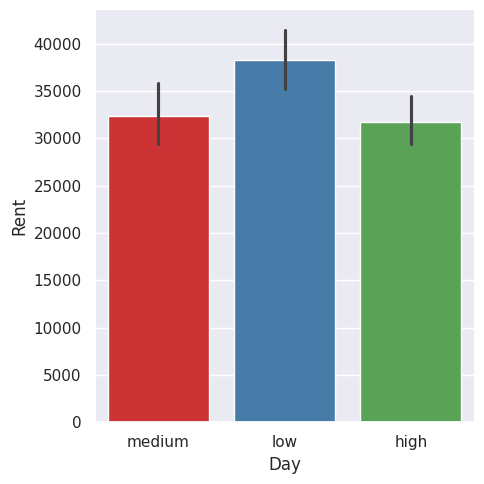

In [206]:
sns.catplot(data=df, kind='bar', x='Day', y='Rent', palette='Set1')

In [207]:
df.head()


,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Total Floors,Month,Day
0,2,10000,1100,0,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,2,5,medium
1,2,20000,800,1,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,5,medium
2,2,17000,1000,1,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,5,medium
3,2,10000,800,1,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2,7,low
4,2,7500,850,1,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2,5,low


In [208]:
df_1 = df.copy()

In [209]:
df = pd.get_dummies(df, drop_first=True)

In [210]:
df.head(3)

,BHK,Rent,Size,Floor,Bathroom,Total Floors,Month,Area Type_Carpet Area,Area Type_Super Area,"Area Locality_ in Erragadda, NH 9",...,City_Kolkata,City_Mumbai,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Builder,Point of Contact_Contact Owner,Day_low,Day_medium
0,2,10000,1100,0,2,2,5,0,1,0,...,1,0,0,1,1,0,0,1,0,1
1,2,20000,800,1,1,3,5,0,1,0,...,1,0,1,0,1,0,0,1,0,1
2,2,17000,1000,1,1,3,5,0,1,0,...,1,0,1,0,1,0,0,1,0,1


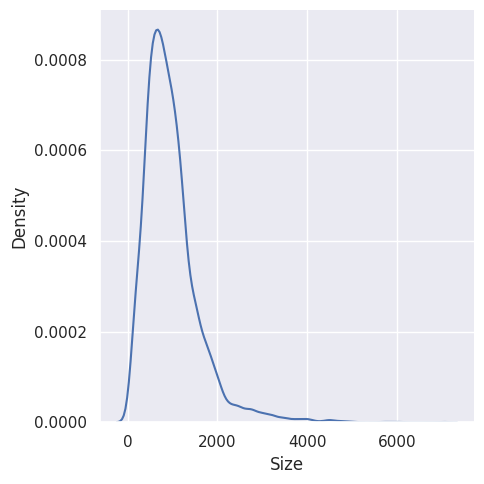

In [211]:
sns.displot(kind='kde', data=df, x='Size')

In [212]:
df['Size_log'] = df['Size'].apply(lambda x: np.log(x+1))

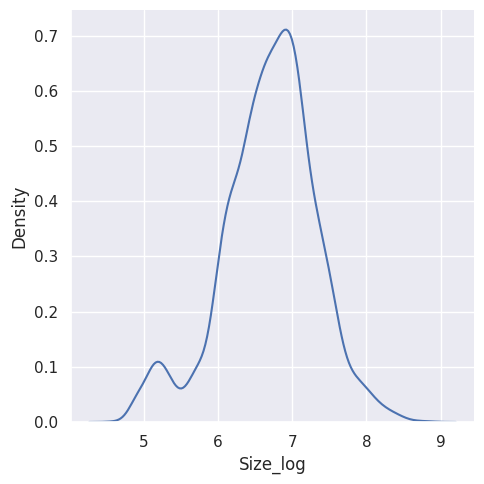

In [213]:
sns.displot(kind='kde', data=df, x='Size_log')

In [214]:
df.drop('Size', axis=1, inplace=True)


In [215]:
df.head()

,BHK,Rent,Floor,Bathroom,Total Floors,Month,Area Type_Carpet Area,Area Type_Super Area,"Area Locality_ in Erragadda, NH 9","Area Locality_ in Miyapur, NH 9",...,City_Mumbai,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Builder,Point of Contact_Contact Owner,Day_low,Day_medium,Size_log
0,2,10000,0,2,2,5,0,1,0,0,...,0,0,1,1,0,0,1,0,1,7.003974
1,2,20000,1,1,3,5,0,1,0,0,...,0,1,0,1,0,0,1,0,1,6.685861
2,2,17000,1,1,3,5,0,1,0,0,...,0,1,0,1,0,0,1,0,1,6.908755
3,2,10000,1,1,2,7,0,1,0,0,...,0,0,1,1,0,0,1,1,0,6.685861
4,2,7500,1,1,2,5,1,0,0,0,...,0,0,1,0,0,0,1,1,0,6.746412


In [216]:
from sklearn.model_selection import train_test_split
X = df.drop('Rent', axis=1)
y = df['Rent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [217]:
X_train.shape, X_test.shape

((3792, 2252), (948, 2252))

In [218]:
from sklearn.preprocessing import StandardScaler


In [219]:
sc = StandardScaler()
X_train['Size_log'] = sc.fit_transform(X_train['Size_log'].to_frame())

In [220]:
X_train.head()

,BHK,Floor,Bathroom,Total Floors,Month,Area Type_Carpet Area,Area Type_Super Area,"Area Locality_ in Erragadda, NH 9","Area Locality_ in Miyapur, NH 9","Area Locality_117 Residency, Chembur East",...,City_Mumbai,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Builder,Point of Contact_Contact Owner,Day_low,Day_medium,Size_log
2482,2,1,1,4,5,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,-0.926666
3864,2,2,2,3,5,0,1,0,0,0,...,0,0,1,1,0,0,1,0,1,0.342912
1671,2,1,2,4,6,0,1,0,0,0,...,0,0,1,1,0,0,1,0,0,0.326924
2118,2,1,2,4,5,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,0.632971
4071,3,3,2,5,7,1,0,0,0,0,...,0,0,0,1,0,0,1,1,0,2.091250


In [221]:
X_test['Size_log'] = sc.transform(X_test['Size_log'].to_frame())

In [222]:
X_test.head()

,BHK,Floor,Bathroom,Total Floors,Month,Area Type_Carpet Area,Area Type_Super Area,"Area Locality_ in Erragadda, NH 9","Area Locality_ in Miyapur, NH 9","Area Locality_117 Residency, Chembur East",...,City_Mumbai,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Builder,Point of Contact_Contact Owner,Day_low,Day_medium,Size_log
3231,3,0,3,1,7,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,1.801033
890,2,5,2,7,5,1,0,0,0,0,...,1,1,0,1,0,0,0,0,1,-0.342198
1147,2,-1,2,16,5,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,-0.179570
2893,1,2,2,3,7,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,-1.113779
2545,2,2,2,4,4,1,0,0,0,0,...,0,1,0,1,0,0,1,0,0,-2.470954


# **Modelling**

**Linear Regression**

In [229]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)

# Evaluation metrics
mae_lm = metrics.mean_absolute_error(y_test,y_pred)
mse_lm =  metrics.mean_squared_error(y_test,y_pred)
rmse_lm =  np.sqrt(mse_lm)

In [230]:
print('MAE:', mae_lm)
print('MSE:', mse_lm)
print('RMSE:', rmse_lm)
print('r2Score:',r2_score(y_test, y_pred))

MAE: 1986720697692.28
MSE: 1.159703185800075e+26
RMSE: 10768951600783.035
r2Score: -4.4245824571449384e+16


**Decision Tree**

In [231]:
dt = DecisionTreeRegressor(random_state = 100)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# Evaluation metrics
mae_dt = metrics.mean_absolute_error(y_test, y_pred)
mse_dt =  metrics.mean_squared_error(y_test, y_pred)
rmse_dt =  np.sqrt(mse_dt)

In [232]:
print('MAE:', mae_dt)
print('MSE:', mse_dt)
print('RMSE:', rmse_dt)
print('r2Score:',r2_score(y_test, y_pred))

MAE: 11625.712025316456
MSE: 838509044.4672996
RMSE: 28957.02064210508
r2Score: 0.6800860380712133


**Support Vector Regressor**

In [233]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

# Evaluation metrics
mae_svr = metrics.mean_absolute_error(y_test, y_pred)
mse_svr =  metrics.mean_squared_error(y_test, y_pred)
rmse_svr =  np.sqrt(mse_svr)

In [234]:
print('MAE:', mae_svr)
print('MSE:', mse_svr)
print('RMSE:', rmse_svr)
print('r2Score:',r2_score(y_test, y_pred))

MAE: 22606.62844404207
MSE: 2886457003.4981065
RMSE: 53725.75735620771
r2Score: -0.10126170017977043


**Random Forest**


In [235]:
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluation metrics
mae_rf = metrics.mean_absolute_error(y_test, y_pred)
mse_rf =  metrics.mean_squared_error(y_test, y_pred)
rmse_rf =  np.sqrt(mse_rf)

In [236]:
print('MAE:', mae_rf)
print('MSE:', mse_rf)
print('RMSE:', rmse_rf)
print('r2Score:',r2_score(y_test, y_pred))

MAE: 8878.08718002813
MSE: 387785665.752039
RMSE: 19692.274265610842
r2Score: 0.8520492420105732


**Lasso Regression**

In [237]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation metrics
mae_clf = metrics.mean_absolute_error(y_test, y_pred)
mse_clf =  metrics.mean_squared_error(y_test, y_pred)
rmse_clf =  np.sqrt(mse_clf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.504e+11, tolerance: 1.442e+09



In [238]:
print('MAE:', mae_clf)
print('MSE:', mse_clf)
print('RMSE:', rmse_clf)
print('r2Score:',r2_score(y_test, y_pred))

MAE: 16052.196261254983
MSE: 1069341827.8172905
RMSE: 32700.792464668048
r2Score: 0.5920170652297108


**Neural Network**

In [241]:
from keras.models import Sequential
from keras.layers import Dense

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Epoch 1/50
119/119 [==============================] - 4s 13ms/step - loss: 4556447744.0000
Epoch 2/50
119/119 [==============================] - 2s 13ms/step - loss: 2896107008.0000
Epoch 3/50
119/119 [==============================] - 1s 9ms/step - loss: 2098736256.0000
Epoch 4/50
119/119 [==============================] - 1s 9ms/step - loss: 1545015680.0000
Epoch 5/50
119/119 [==============================] - 1s 9ms/step - loss: 1192971136.0000
Epoch 6/50
119/119 [==============================] - 1s 9ms/step - loss: 979038208.0000
Epoch 7/50
119/119 [==============================] - 1s 9ms/step - loss: 1104023936.0000
Epoch 8/50
119/119 [==============================] - 1s 9ms/step - loss: 855277184.0000
Epoch 9/50
119/119 [==============================] - 1s 9ms/step - loss: 690929280.0000
Epoch 10/50
119/119 [==============================] - 1s 9ms/step - loss: 558117504.0000
Epoch 11/50
119/119 [==============================] - 1s 9ms/step - loss: 541481024.0000
Epoch 12/50

Neural network didnt perform well for the data

By fitting most of the available to the processed data by removing outliers and applying transformations
we can see that RandomForestRegressor has performed well in the case of r2_score(0.852) which shows the variance of the rent(output label).
The mean absolute error is also small when this model is applied to the data (8878.08)